# Pandaman Meme Generator

In [1]:
import dlib, face_recognition, cv2, math
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

In [2]:
# Baidu's censoring API
from utils import *
from config import *

access_token = get_token(API_KEY, SECRET_KEY)

In [3]:
img_path = 'wyg.jpg'
bg_path = 'bg.jpg'
SHAPE_PREDICTOR_PATH = 'shape_predictor_68_face_landmarks.dat' # download from https://github.com/davisking/dlib-models
flipped_horizontally = True

In [4]:
# initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor(SHAPE_PREDICTOR_PATH)

## STEP 1：load the input image and use dlib to detect face

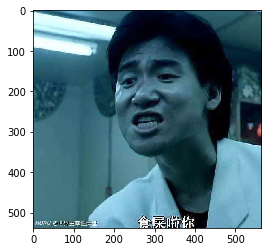

In [5]:
# load the input image
img = face_recognition.load_image_file(img_path)
plt.imshow(img)

In [6]:
# censor content here
result = censor_image('wyg.jpg', access_token)
print(result)

data = '\n不合规\n'
if result['conclusion'] == '不合规':
    for i, d in enumerate(result['data']):
        data += '%s：%s \n' %(str(i+1), d['msg'])
    # raise Exception(data)
    print(data)

{'conclusion': '不合规', 'log_id': 15436787380678507, 'data': [{'msg': '存在水印码内容', 'probability': 0.8836372, 'type': 5}, {'msg': '存在公众人物', 'stars': [{'probability': 0.72439754, 'name': '张学友'}], 'type': 11}], 'conclusionType': 2}

不合规
1：存在水印码内容 
2：存在公众人物 



In [7]:
# detect faces
dets = detector(img, 1)
print("%i faces found in source image." % len(dets))

1 faces found in source image.


## STEP 2：extract facial landmarks using dlib to draw the bottom line and top line

In [8]:
top_line = []
bottom_line = []

for d in dets:
   left_top = (dlib.rectangle.left(d), dlib.rectangle.top(d))
   right_bottom = (dlib.rectangle.right(d), dlib.rectangle.bottom(d))
   landmarks_array = landmark_predictor(img, d)

for i in range(68):
   cv2.circle(img, (landmarks_array.part(i).x, landmarks_array.part(i).y), 2, (0,255,0), -1, 8)

for i in range(16):
   for j in range(landmarks_array.part(i+1).x - landmarks_array.part(i).x):
       y_value = j*(landmarks_array.part(i+1).y - landmarks_array.part(i).y) / (landmarks_array.part(i+1).x - landmarks_array.part(i).x) + landmarks_array.part(i).y
       bottom_line.append((j + landmarks_array.part(i).x,y_value))

bottom_line.append((landmarks_array.part(16).x, landmarks_array.part(16).y))

for i in range(len(bottom_line)):
   cv2.circle(img, (bottom_line[i][0],int(bottom_line[i][1])), 2, (0,255,0), -1, 8)


for i in range(landmarks_array.part(17).x - landmarks_array.part(0).x):
   y_value = i * (landmarks_array.part(17).y - landmarks_array.part(0).y) / (landmarks_array.part(17).x - landmarks_array.part(0).x) + landmarks_array.part(0).y
   top_line.append((i+landmarks_array.part(0).x,y_value))

for i in range(9):
   for j in range(landmarks_array.part(i+18).x - landmarks_array.part(i+17).x):
       y_value = j * (landmarks_array.part(i+18).y - landmarks_array.part(i+17).y) / (landmarks_array.part(i+18).x - landmarks_array.part(i+17).x) + landmarks_array.part(i+17).y
       top_line.append((j + landmarks_array.part(i+17).x, y_value))

for i in range(landmarks_array.part(16).x - landmarks_array.part(26).x):
   y_value = i * (landmarks_array.part(16).y - landmarks_array.part(26).y) / (landmarks_array.part(16).x - landmarks_array.part(26).x) + landmarks_array.part(26).y
   top_line.append((i+landmarks_array.part(26).x, y_value))

for i in range(len(top_line)):
   cv2.circle(img,(top_line[i][0], int(top_line[i][1])), 2, (0,255,0), -1, 2)

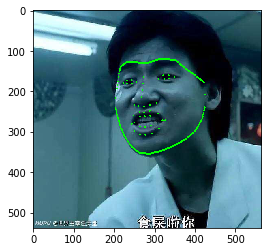

In [9]:
plt.imshow(img)
# cv2.imwrite("Facial_contour.jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

## STEP 3：convert the image to grayscale

In [10]:
img = Image.open(img_path)
img = img.convert('L')

## STEP 4：paint the pixels outside the lines white

In [11]:
(w,h) = img.size
for x in range(w):
   for y in range(h):
       if not (top_line[0][0] <= x <= top_line[-1][0]):
           img.putpixel((x,y), 255)
       elif not (top_line[x - top_line[0][0]][1] <= y <= bottom_line[x - bottom_line[0][0]][1]):
           img.putpixel((x,y), 255)
       else:
           distance = []
           for i in range(len(bottom_line)):
               delta_x = abs(x - bottom_line[i][0])
               delta_y = abs(y - bottom_line[i][1])
               distance_i = math.sqrt(delta_x*delta_x + delta_y*delta_y)
               distance.append(distance_i)
           if min(distance) < 30:
               img.putpixel((x,y), 255)

(223, 180)
(167, 93, 390, 316)
(56, 87)


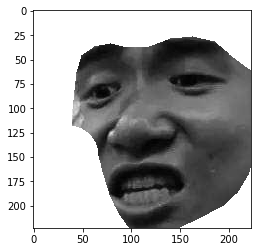

In [12]:
box = (dlib.rectangle.left(d), dlib.rectangle.top(d), dlib.rectangle.right(d), dlib.rectangle.bottom(d))
eye_pos = (landmarks_array.part(36).x,landmarks_array.part(36).y)
print(eye_pos)
newImg = img.crop(box)
eye_pos = (eye_pos[0] - dlib.rectangle.left(d),eye_pos[1] - dlib.rectangle.top(d))
print(box)
print(eye_pos)

plt.imshow(newImg)

## STEP 5：crop and resize the image, leave 9% black, 4% gray, and the rest white

In [13]:
(original_w,original_h) = newImg.size
resizedImg = newImg.resize((280,280))
(w,h) = resizedImg.size
eye_pos = (eye_pos[0]*w/float(original_w),eye_pos[1]*h/float(original_h))

pixel_array = []

for x in range(w):
   for y in range(h):
       pos = (x,y)
       rgb = resizedImg.getpixel(pos)
       pixel_array.append(rgb)

pixel_array.sort()

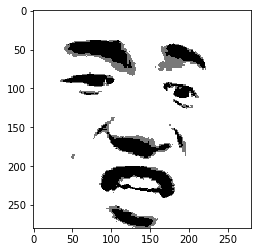

In [14]:
for x in range(w):
   for y in range(h):
       pos = (x,y)
       rgb = resizedImg.getpixel(pos)
       if rgb < pixel_array[int(0.09*w*h)]:
           resizedImg.putpixel(pos,0)
       elif pixel_array[int(0.09*w*h)] <= rgb <= pixel_array[int(0.13*w*h)]:
           resizedImg.putpixel(pos,120)
       else:
           resizedImg.putpixel(pos,255)

if flipped_horizontally:
    resizedImg = resizedImg.transpose(Image.FLIP_LEFT_RIGHT)
            
plt.imshow(resizedImg)

## STEP 6：paste the adjusted picture onto the panda's head

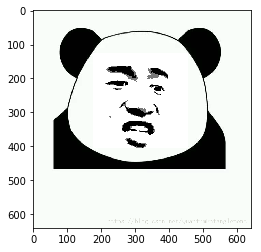

In [15]:
imagePanda = Image.open(bg_path)
# imagePanda.paste(resizedImg,(int(250 - eye_pos[0]),int(185 - eye_pos[1])))

imagePanda.paste(resizedImg,(175, 125))
plt.imshow(imagePanda)

## STEP 7：add text whatever you like

请输入文字：食屎啦你
{'spam': 1, 'review': [], 'reject': [{'score': 0.77799999713898, 'hit': [], 'label': 5}], 'pass': [{'score': 0.0010000000474975, 'hit': [], 'label': 1}, {'score': 0.12999999523163, 'hit': [], 'label': 2}, {'score': 0, 'hit': [], 'label': 3}, {'score': 0.19388014925373, 'hit': [], 'label': 4}]}
请输入文字：你对力量一无所知
{'spam': 0, 'review': [], 'reject': [], 'pass': [{'score': 0.003000000026077, 'hit': [], 'label': 1}, {'score': 0.075000002980232, 'hit': [], 'label': 2}, {'score': 0, 'hit': [], 'label': 3}, {'score': 0.22532483443709, 'hit': [], 'label': 4}, {'score': 0.029999999329448, 'hit': [], 'label': 5}]}


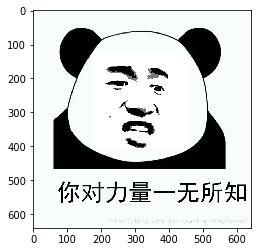

In [16]:
draw = ImageDraw.Draw(imagePanda)
ttfront = ImageFont.truetype("simhei.ttf",70)

# censor content here
rude = True
while rude:
    text = input("请输入文字：")
    result = censor_text(text, access_token)['result']
    print(result)
    if result['reject'] == []:
        rude = False
    else:
        continue

draw.text((70,500), text, fill=(0,0,0), font=ttfront)
imagePanda.save("panda.png")
plt.imshow(imagePanda)

## STEP 8：increase contrast to make image's edge soft

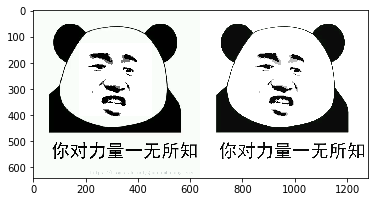

In [17]:
img = cv2.imread('panda.png')
res = np.uint8(np.clip((1.5 * img + 10), 0, 255))
cv2.imwrite("panda.png", res)

tmp = np.hstack((img, res))  # Just for comparison
plt.imshow(tmp)

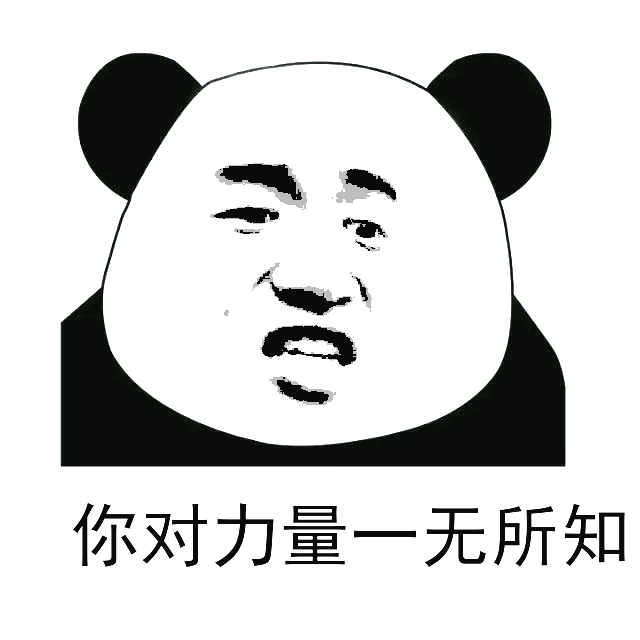

In [18]:
Image.open("panda.png")